In [84]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

%run -i 'model_helpers.py'
%run -i 'models.py'

In [2]:
df = load_query_avg_data_exp2() # see data_helpers.py
df = df[df["condition"]!=2] # filter out "warm/snowy" as per paper
df.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,windy,0.733333
1,0,0,AandB,windy and cloudy,0.773333
2,0,0,AandnotB,windy and not cloudy,0.676667
3,0,0,AgB,windy given cloudy,0.816667
4,0,0,AgnotB,windy given not cloudy,0.600000


In [3]:
X_data, y_data = make_model_data(df) # see data_helpers.py

# Bayesian sampler model

One thing to figure out is whether this should follow the paper and constraint $\beta \in [0,1]$ or allow it to vary more freely. From what I can tell there's no reason to think it couldn't be greater than 1, I believe they just added this constraint to make it easier to compare the parameters across models.

In [60]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [61]:
# mcmc_bs.print_summary()

Participant mean response corr =  0.685
Query-level corr 0.854


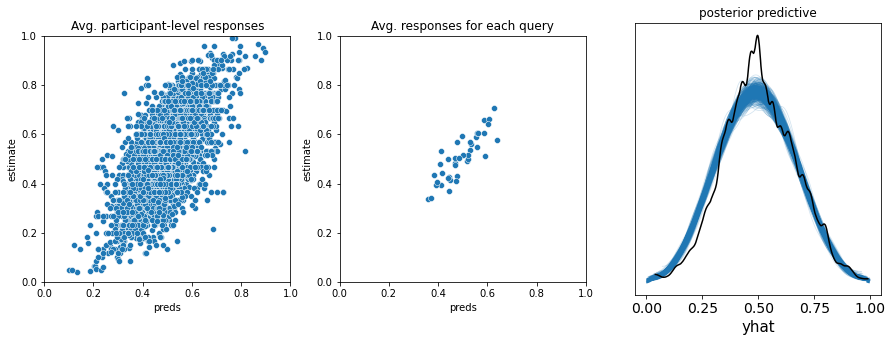

In [62]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs)

# Relative Frequency model


In [63]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [64]:
# mcmc_rf.print_summary()

Participant mean response corr =  0.517
Query-level corr 0.64


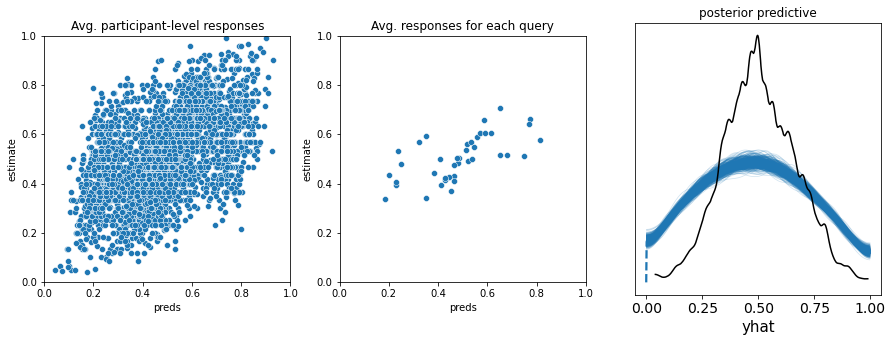

In [65]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py
plot_model_preds(df, az_data_rf)

# Probability theory plus noise (PT+N) model

In [66]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [67]:
# mcmc_ptn.print_summary()

Participant mean response corr =  0.668
Query-level corr 0.841


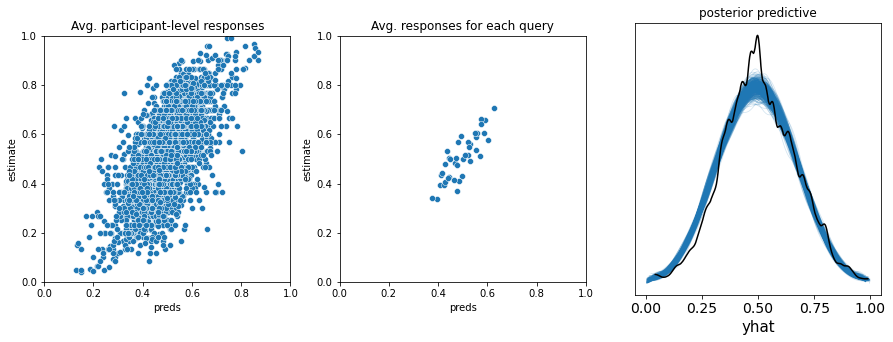

In [68]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn)

In [13]:
az.compare({"P+TN":az_data_ptn, "Bayesian Sampler": az_data_bs, "Relative Freq.":az_data_rf}, scale="deviance", ic="loo")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Bayesian Sampler,0,-3881.005671,418.245612,0.000000,0.842152,83.065265,0.000000,True,deviance
P+TN,1,-3769.284205,397.915260,111.721465,0.155407,82.123881,25.806678,True,deviance
Relative Freq.,2,-1283.211329,426.448951,2597.794341,0.002441,92.109998,80.968748,True,deviance


Here there are some "very bad" samples, so need to run `reloo()` to fix those, following this [arviz tutorial](https://arviz-devs.github.io/arviz/user_guide/numpyro_refitting_xr_lik.html) (per this [stackoverflow post](https://stats.stackexchange.com/questions/304958/warnings-during-waic-computation-how-to-proceed)).

But if these can be trusted, Bayesian Sampler is the winning model. Interesting to me the RF has a higher p_loo than both, given that it has fewer parameters. I wonder if that's because it just can't get any good estimates so has lots of variance?

# Summary and comparison of models

All three models have now been implemented as probabilistic programs, and we have obtained samples for each. [This paper](https://arxiv.org/abs/1507.04544) describes how to compare them using information criteria.

* Both the PT+N and Bayesian sampler models are far better than the naive relative frequency model.
* If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then the PT+N and Bayesian sampler models are essentially indistinguishable. 
* But if you constrain $\beta \in [0,1]$, then according to $loo_{ic}$ the PT+N model is the best (now that I have fixed my code) and the Bayesian Sampler is in second. 

# Hierarchical Bayesian Sampler

Here's a quick implementation of a hierarchical version of the Bayesian Sampler, which requires reparameterization of some components. It samples reasonably quickly and does better in terms of $loo_{ic}$ as well as $R^2$ on the trial averages.

In [69]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm, target_accept_prob=.90), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=2)
# 
mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.688
Query-level corr 0.876


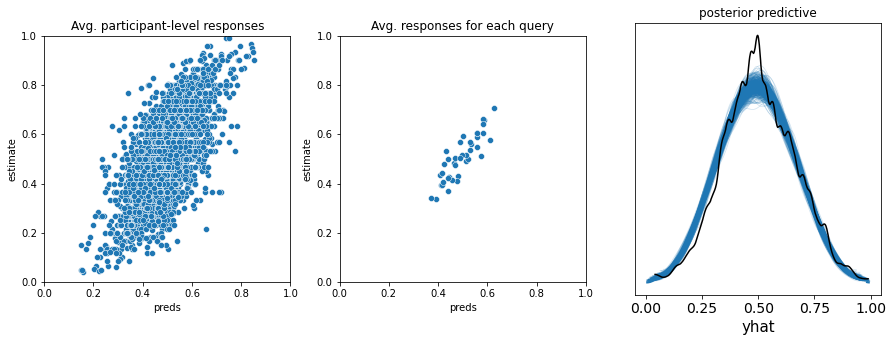

In [70]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm)

## with restricted $\beta \in [0,1]$

In [283]:
# %run -i 'models.py'
mcmc_bs_mlm_restricted = MCMC(NUTS(bayesian_sampler_complex_mlm_restricted, target_accept_prob=.90), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_bs_mlm_restricted.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [71]:
az_data_bs_mlm_restricted = make_arviz_data(mcmc_bs_mlm_restricted, bayesian_sampler_complex_mlm_restricted, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm_restricted)

NameError: name 'mcmc_bs_mlm_restricted' is not defined

# Hierarchical PT+N


In [74]:
mcmc_ptn_mlm = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [75]:
# mcmc_ptn_mlm.print_summary()

Participant mean response corr =  0.659
Query-level corr 0.835


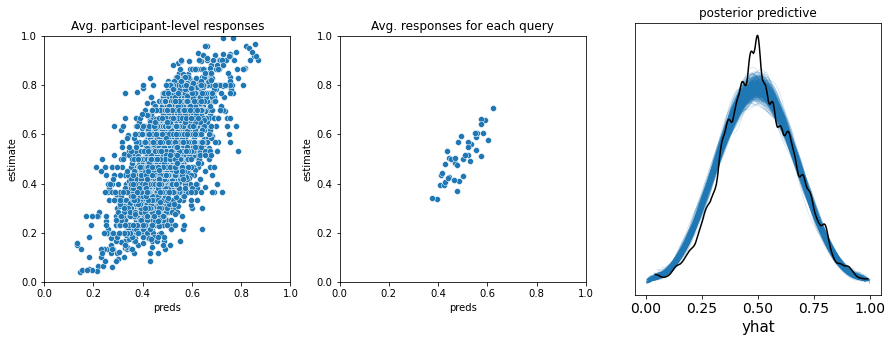

In [76]:
az_data_ptn_mlm = make_arviz_data(mcmc_ptn_mlm, PTN_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm)

## removing constructive conditional probability component



In [ ]:
# %run -i 'models.py'
mcmc_ptn_mlm_simplecond = MCMC(NUTS(PTN_complex_mlm_simplecond, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn_mlm_simplecond.run(random.PRNGKey(0), X_data, y_data)

In [ ]:
az_data_ptn_mlm_simplecond = make_arviz_data(mcmc_ptn_mlm_simplecond, PTN_complex_mlm_simplecond, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm_simplecond)

In [340]:
az.compare(
    {
        "PTN_mlm":az_data_ptn_mlm, 
        "BS_mlm": az_data_bs_mlm,
        "BS_mlm_restricted": az_data_bs_mlm_restricted,
        "PTN_mlm_simplecond": az_data_ptn_mlm_simplecond
    }, 
    scale="deviance", ic="loo", method="BB-pseudo-BMA")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
PTN_mlm_simplecond,0,-3954.710217,367.684889,0.000000,8.580055e-01,81.681638,0.000000,True,deviance
BS_mlm,1,-3949.494874,373.593576,5.215343,1.419945e-01,82.021835,3.423648,True,deviance
PTN_mlm,2,-3795.061797,355.915393,159.648419,7.817805e-25,81.879254,21.336174,True,deviance
BS_mlm_restricted,3,-3791.863782,414.581630,162.846435,1.303885e-22,82.229192,24.092227,True,deviance


Bayesian Sampler conditional response corr =  0.718
Bayesian Sampler conditional query-level corr 0.923


<AxesSubplot:xlabel='preds', ylabel='estimate'>

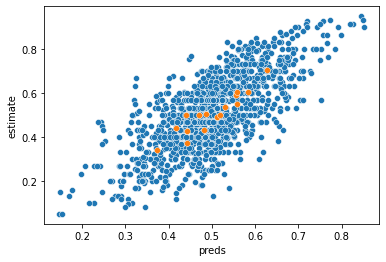

In [338]:
# zoom in on conditional trials

d = df
d["preds"] = az_data_bs_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],3))
sns.scatterplot(x = d.preds, y = d.estimate)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],3))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

PT+N conditional response corr =  0.67
PT+N conditional query-level corr 0.855


<AxesSubplot:xlabel='preds', ylabel='estimate'>

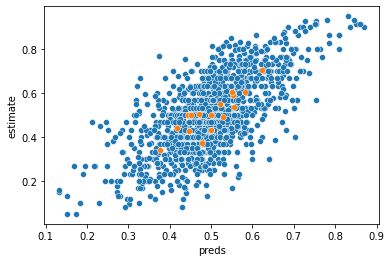

In [339]:
d = df
d["preds"] = az_data_ptn_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]

trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("PT+N conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],3))
sns.scatterplot(x = d.preds, y = d.estimate)
print("PT+N conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],3))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

Descriptively, the Bayesian Sampler does a better job predicting for conditional trials than does the PT+N model. That's consistent with the the diagnosis that the problem with the PT+N model is its account of conditional probability judgments, although the Bayesian sampler model is also showing a better correlation for non-conditional judgments. My guess there is the estimation of the PT+N model parameters are being biased by its incorrect specification for conditional probability trials.

# Summary of hierarchical models

If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then a hierarchical implementation of that model pulls ahead of a hierarchical implementation of PT+N. If you strip out the constructive account of conditional probability judgments from PT+N, then it is perhaps slightly better still, but it is not reliably distinguishable by $loo_{ic}$. The models are fundamentally equivalent at this point so any differences probably owe to implementation of the priors and internal parameterization of $d$ vs $N$.

If these results are to be trusted it's pretty decisive in favor of the Bayesian Sampler models account of conditional probability (these judgments are just like simple probability judgments) and therefore the Bayesian Sampler theory. As for whether we should appeal to "noise" or "priors", as Zhu and colleage's point out they are essentially indistinguishable at this point. Certain degrees of noise act like certain priors, and vice versa.

### A few concerns

* how can I better align the priors to equate the models in terms of complexity, or at least to best configure them for each model?
* Am I inadvertantly putting a weird prior on d or N in the hierarchical models?

<AxesSubplot:title={'center':'N_prime_pop'}>

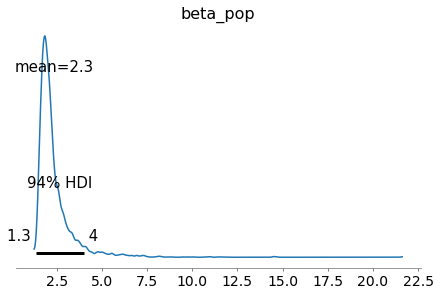

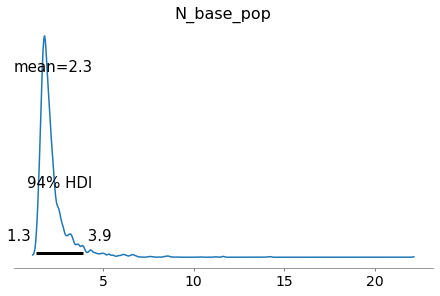

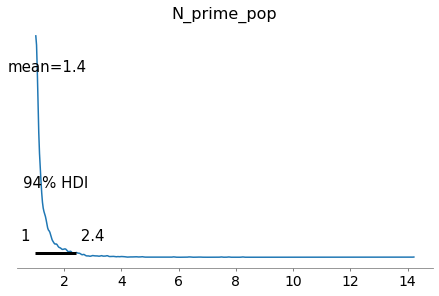

In [21]:
az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_pop"], transform=np.exp)
# az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_sd", "N_prime_sd", "N_delta_sd"], transform=np.exp)

az_data_bs_mlm.posterior["N_base_pop"] = 1 + np.exp(az_data_bs_mlm.posterior.N_prime_pop) + np.exp(az_data_bs_mlm.posterior.N_delta_pop)
az.plot_posterior(az_data_bs_mlm, var_names=["N_base_pop"])
az.plot_posterior(az_data_bs_mlm, var_names=["N_prime_pop"], transform = lambda x: 1 + np.exp(x))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

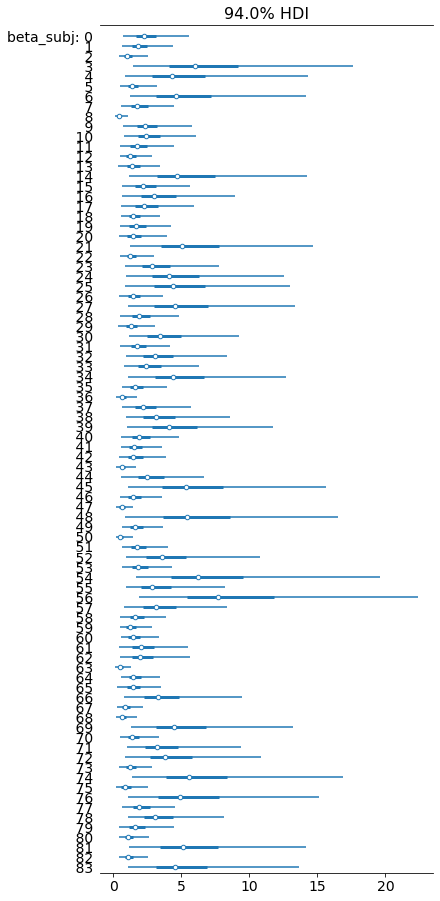

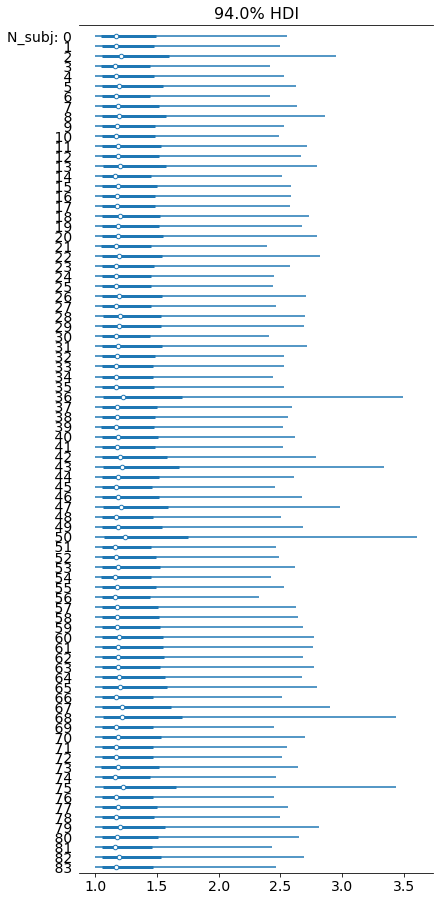

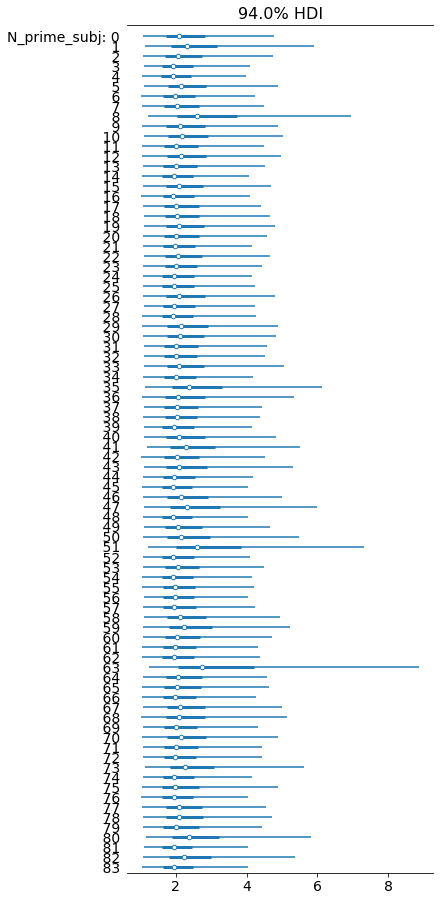

In [352]:
az.plot_forest(data=az_data_bs_mlm, var_names=["beta_subj"],  combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["N_subj"], combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["N_prime_subj"], combined=True)

## PT+N

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

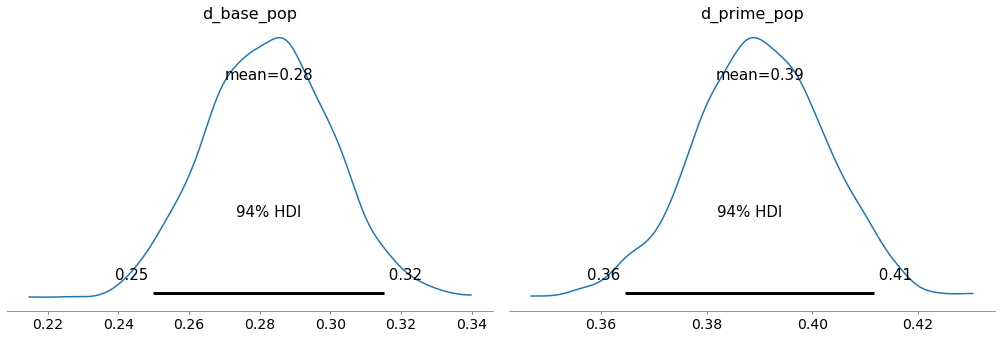

In [357]:
az_data_ptn_mlm.posterior["d_prime_pop"] = az_data_ptn_mlm.posterior.d_base_pop + np.exp(az_data_ptn_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_ptn_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

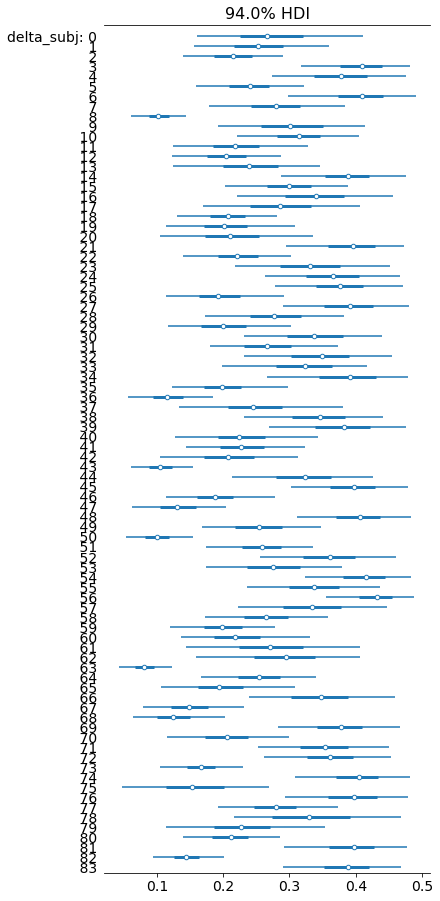

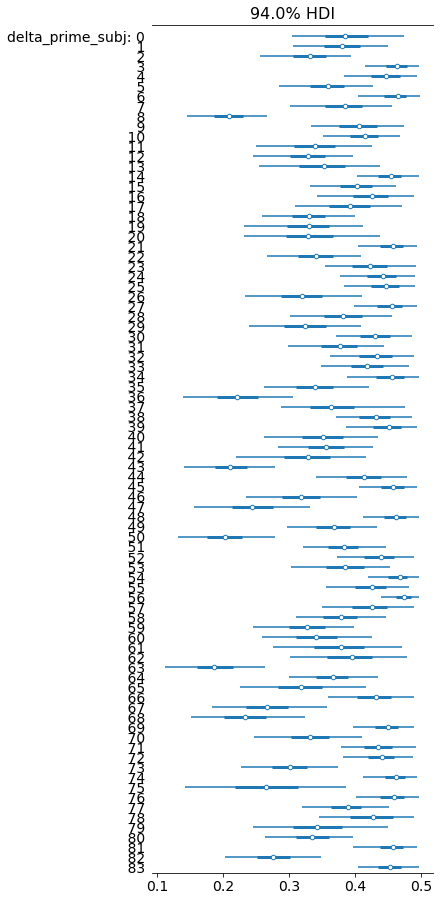

In [358]:
az.plot_forest(data=az_data_ptn_mlm, var_names=["delta_subj"], combined=True)
az.plot_forest(data=az_data_ptn_mlm, var_names=["delta_prime_subj"], combined=True)

# Mixture models

## Bayesian Sampler multilevel + mixture model

This needs a bit of work to get it sampling properly. No divergences, but seeing some very bad $\hat{R}$s for some parameters and the $loo_{ic}$ warnings look somewhat serious.

In [85]:
mcmc_bs_mlm_mix = MCMC(NUTS(bayesian_sampler_complex_mlm_mix, target_accept_prob=.95), 
               num_warmup = 2_000, 
               num_samples = 2_000, 
               num_chains = 2)

mcmc_bs_mlm_mix.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [86]:
az_data_bs_mlm_mix = make_arviz_data(mcmc_bs_mlm_mix, bayesian_sampler_complex_mlm_mix, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs_mlm_mix))

num divergences = 0


Participant mean response corr =  0.688
Query-level corr 0.877


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pop,0.770,0.354,0.270,1.460,0.018,0.013,435.0,712.0,1.02
N_prime_pop,-1.741,1.488,-4.508,0.928,0.153,0.108,84.0,674.0,1.04
N_delta_pop,-0.197,0.459,-1.007,0.794,0.034,0.024,186.0,161.0,1.01
beta_sd,0.792,0.112,0.600,1.013,0.005,0.003,551.0,446.0,1.01
N_prime_sd,0.591,0.470,0.029,1.427,0.172,0.126,5.0,26.0,1.37
N_delta_sd,0.392,0.431,0.011,1.259,0.116,0.084,7.0,26.0,1.27
mixing[0],0.968,0.008,0.953,0.984,0.000,0.000,2902.0,1145.0,1.00
mixing[1],0.032,0.008,0.016,0.047,0.000,0.000,2902.0,1145.0,1.00


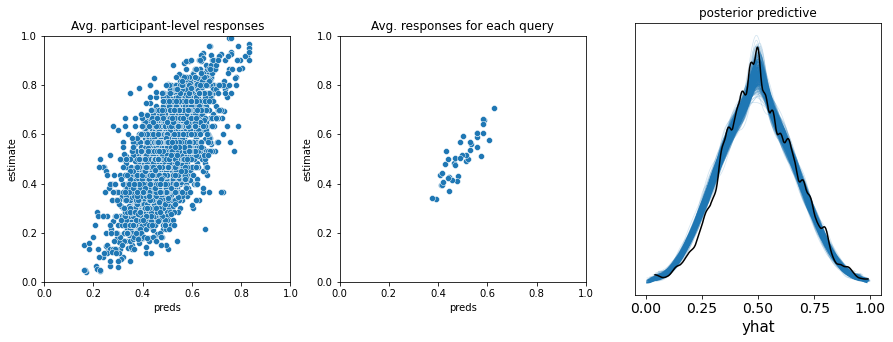

In [87]:
plot_model_preds(df, az_data_bs_mlm_mix)
main_vars = [ "beta_pop", "N_prime_pop", "N_delta_pop", "beta_sd", "N_prime_sd", "N_delta_sd", "mixing"]
az.summary(az_data_bs_mlm_mix2, var_names=main_vars)

## PT+N multilevel + mixture model

In [58]:
mcmc_ptn_mlm_mix = MCMC(NUTS(PTN_complex_mlm_mix, target_accept_prob=.95), 
               num_warmup = 2_000, 
               num_samples = 2_000, 
               num_chains = 2)

mcmc_ptn_mlm_mix.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

num divergences = 0
Participant mean response corr =  0.659
Query-level corr 0.836


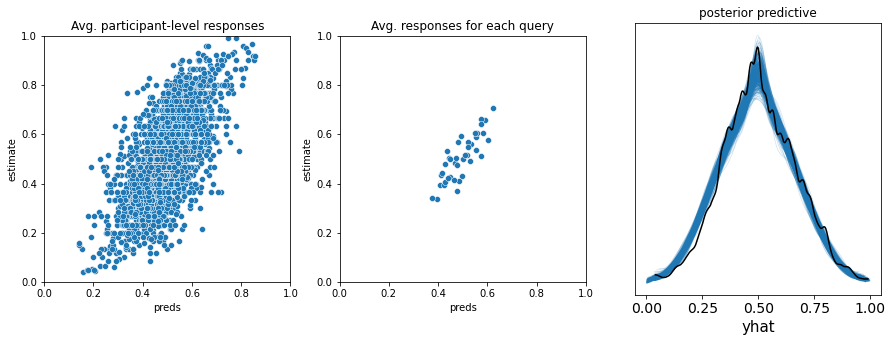

In [59]:
az_data_ptn_mlm_mix = make_arviz_data(mcmc_ptn_mlm_mix, PTN_complex_mlm_mix, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_ptn_mlm_mix))
plot_model_preds(df, az_data_ptn_mlm_mix)

compare all the models

In [80]:
az.compare(
    {
        "PTN_mlm":az_data_ptn_mlm, 
        "BS_mlm": az_data_bs_mlm,
        "PTN_mlm_mix":az_data_ptn_mlm_mix, 
        "BS_mlm_mix": az_data_bs_mlm_mix,
        "P+TN":az_data_ptn, 
        "Bayesian Sampler": az_data_bs, 
        "Relative Freq.":az_data_rf
    }, 
    scale="deviance", ic="loo", method="BB-pseudo-BMA")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
BS_mlm_mix,0,-3964.643349,369.620666,0.000000,NaN,76.861586,0.000000,True,deviance
BS_mlm,1,-3949.498708,373.591659,15.144641,NaN,75.364276,9.422240,True,deviance
Bayesian Sampler,2,-3881.005671,418.245612,83.637678,NaN,77.842149,17.777454,True,deviance
PTN_mlm_mix,3,-3809.894546,355.838029,154.748803,NaN,78.294240,20.898512,True,deviance
PTN_mlm,4,-3795.061786,355.915398,169.581563,NaN,75.575341,23.300450,True,deviance
P+TN,5,-3769.284205,397.915260,195.359143,NaN,76.335614,24.583248,True,deviance
Relative Freq.,6,-1283.211329,426.448951,2681.432019,0.0,91.167083,87.822562,True,deviance


In [88]:
az.loo(az_data_bs_mlm_mix, scale="deviance", pointwise=True)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3962.66    80.69
p_loo          370.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3291   97.9%
 (0.5, 0.7]   (ok)         61    1.8%
   (0.7, 1]   (bad)         7    0.2%
   (1, Inf)   (very bad)    1    0.0%

In [92]:
a_vec = jnp.stack([jnp.ones(10)*2, jnp.ones(10)*4, jnp.ones(10)*4], -1)
b_vec = jnp.stack([jnp.ones(10)*2, jnp.ones(10)*4, jnp.ones(10)*4], -1)
mixing_vec = jnp.stack([jnp.ones(10)*.5, jnp.ones(10)*.5, jnp.ones(10)*.5], -1)
MixtureBeta(a_vec, b_vec, mixing_vec).sample(random.PRNGKey(0))

DeviceArray([0.11877543, 0.5712513 , 0.94381255, 0.4864969 , 0.7263023 ,
             0.3707984 , 0.8475313 , 0.8362999 , 0.74998975, 0.75741285],            dtype=float32)

In [95]:
z = dist.Dirichlet(jnp.ones((3)))

# z.sample(random.PRNGKey(1))[0,:]
with numpyro.plate("whatever", 5):
    x = numpyro.sample("test", z, rng_key = random.PRNGKey(0))

    
MixtureBeta(a_vec, b_vec, x[[1,2,3,4,5,1,2,3,4,5],:,...]).sample(random.PRNGKey(0))

DeviceArray([0.5556874 , 0.5712513 , 0.94381255, 0.6299685 , 0.8138755 ,
             0.3707984 , 0.8475313 , 0.8362999 , 0.5848643 , 0.75741285],            dtype=float32)